# Segment Anything: an End to End Example

In this tutorial, we will walk through an end-to-end AI example, with Meta's most recent [Segment Anything](https://github.com/facebookresearch/segment-anything) model. Specifically, we will implement the functionality that takes an image and an optional prompt, and produces a segmentation mask, either as a list of structured boolean masks, or as a single overlayed image for display.

In this walkthrough, you'll learn how to:
- Specify dependencies for a photon, including dependencies that are github repositories.
- Use the `@Photon.handler` decorator to define handlers for a photon, and annotate the arguments and return values for better user experience.
- Return different types of outputs from a photon deployment.
- Use the python client to connect and interact with the deployment in nontrivial ways.

The code for this tutorial is also available in the LeptonAI example repository [here](https://github.com/leptonai/examples/tree/main/advanced/segment-anything).

First, let's install the necessaries.

In [1]:
# To run locally, we will first make sure that the dependencies are all installed.
!pip install -r requirements.txt > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7l55a330


## Running the code locally

Note: if you do not have a local GPU, skip to <a href=#remote>the next section</a>.

The code, `sam.py`, live under the same folder as this ipython notebook. Feel free to check it out. We will move on to running it. Let's first see if we have a GPU.

We will briefly check if we actually have GPUs.

In [2]:
import torch
if not torch.cuda.is_available():
    print("Actually, running without a GPU is quite slow and not recommended.")

Now, let's run the photon. Since we are in the ipython notebook, we will use the subprocess module to spawn the local deployment. If you are going to run it manually, feel free to just run `python sam.py`.

In [3]:
from subprocess import Popen
import time
process = Popen(['python', 'sam.py'])

2023-08-09 00:20:06.728 | INFO     | __main__:init:98 - Checkpoint already exists at /tmp/sem-checkpoint/sam_vit_h_4b8939.pth. Reusing it.
2023-08-09 00:20:06.728 | INFO     | __main__:init:104 - Loading checkpoint. This might take some time.
2023-08-09 00:20:13,695 - INFO:  If you are using standard photon, a few urls that may be helpful:	
2023-08-09 00:20:13,695 - INFO:  	- http://0.0.0.0:8080/docs OpenAPI documentation	
2023-08-09 00:20:13,695 - INFO:  	- http://0.0.0.0:8080/redoc Redoc documentation	
2023-08-09 00:20:13,695 - INFO:  	- http://0.0.0.0:8080/openapi.json Raw OpenAPI schema	
2023-08-09 00:20:13,695 - INFO:  	- http://0.0.0.0:8080/metrics Prometheus metrics	
2023-08-09 00:20:13,715 - INFO:     Started server process [359561]
2023-08-09 00:20:13,715 - INFO:     Waiting for application startup.
2023-08-09 00:20:13,716 - INFO:     Application startup complete.
2023-08-09 00:20:13,717 - INFO:     Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)


Wait for the above process to start. Because it is loading the checkpoing and making initializations, it will take quite some time, especially if we need to download the checkpoints. Towards the end, you will see "Uvicorn running on http://0.0.0.0:8080" (or another port) - this means the service is successfully running.

Now, let's use the lepton sdk client to communicate to the service.

In [4]:
from leptonai.client import Client, local
# Note: if the port above is not 8080 (the default), specify the port with local(port=xxxx).
c = Client(local())
print("Possible paths are:")
print(c.paths())

2023-08-09 00:20:25,423 - INFO:     127.0.0.1:57944 - "GET /openapi.json HTTP/1.1" 200 OK
Possible paths are:
dict_keys(['/predict_url', '/generate_mask'])


In [5]:
# This prints the doc string for the `predict_url` endpoint
print(c.predict_url.__doc__)

This is the predict_url endpoint. It takes in an image url, calls the mask generator, and
returns the masks. We also do proper error handling here: if the image cannot opened, or
if the mask cannot be generated, we will return a proper http error back to the user side.

Automatically inferred parameters from openapi:

Input Schema (*=required):
  url*: string
  prompt: string

Example input:
  url: https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg
  prompt: Please segment the koala.


Output Schema:
  output: object


Let's use the example URL to segment the coala and get the results back. Note that `predict_url` returns a lepton pickled object - and we will use `lepton_unpickle` to get the actual content.

In [6]:
from leptonai.photon.types import is_pickled, lepton_unpickle
from pprint import pprint # pretty print

result = c.predict_url(
    url="https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg",
    prompt="Please segment the koala.",
)
# check if the result is actually a lepton pickled object.
assert is_pickled(result)
result = lepton_unpickle(result)
print(f"A total of {len(result)} segmentation masks.")
print("Raw content of the first segmentation mask:")
pprint(result[0])

2023-08-09 00:20:40,358 - INFO:     127.0.0.1:35960 - "POST /predict_url HTTP/1.1" 200 OK
A total of 27 segmentation masks.
Raw content of the first segmentation mask:
{'area': 419621,
 'bbox': [424, 0, 707, 1111],
 'crop_box': [0, 0, 1132, 1113],
 'point_coords': [[937.4375, 52.171875]],
 'predicted_iou': 1.0537316799163818,
 'segmentation': array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
 'stability_score': 0.9850172400474548}


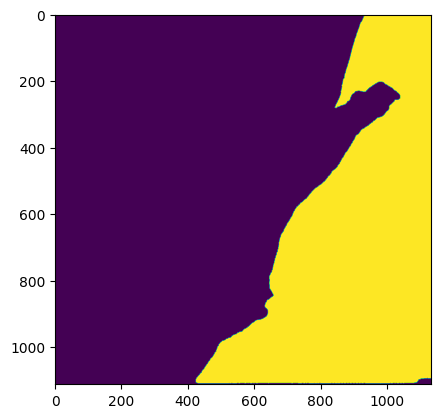

In [7]:
# Let's show the first segmentation mask.
from matplotlib import pyplot
pyplot.imshow(result[0]['segmentation'])

You can then freely use the returned result to do other work like you regularly do in Python.

We will also show how to get a direct mask image using `generate_mask`, and we'll also try calling without the prompt:

2023-08-09 00:20:58,182 - INFO:     127.0.0.1:58508 - "POST /generate_mask HTTP/1.1" 200 OK


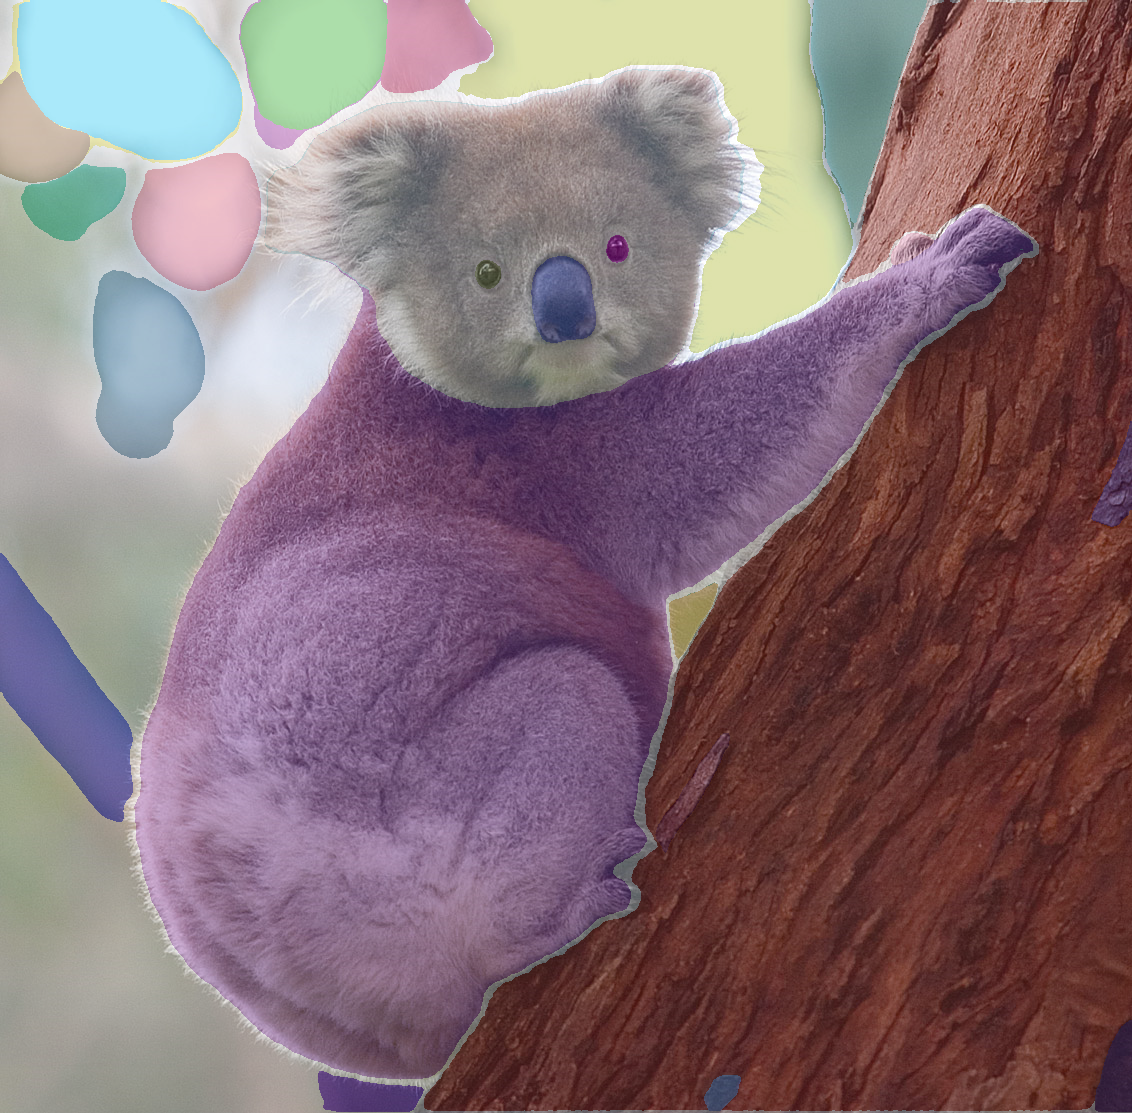

In [8]:
mask = c.generate_mask(
    url="https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg",
)
from IPython.display import display, Image
display(Image(data=mask, width=400))

In [9]:
# Once we are done, let's close up the local process.
process.kill()

## Running remotely <a name="remote" />

Let's try to run the photon remotely by creating, pushing, and running the photon remotely. First, let's log in.

Go to [https://dashboard.lepton.ai/credentials](https://dashboard.lepton.ai/credentials), log in, and copy your workspace's credentials to the below line, replacing `INSERT_YOUR_CREDENTIAL_HERE`. The credential looks like `jazwwwt0:dsfsdweldhifdsfdsfd`.

In [10]:
!lep login -c INSERT_YOUR_CREDENTIAL_HERE

    _     _____ ____ _____ ___  _   _       _    ___     
   | |   | ____|  _ \_   _/ _ \| \ | |     / \  |_ _|    
   | |   |  _| | |_) || || | | |  \| |    / _ \  | |     
   | |___| |___|  __/ | || |_| | |\  |   / ___ \ | |     
   |_____|_____|_|    |_| \___/|_| \_|  /_/   \_\___|    
                                                         
Hint: If you have multiple workspaces, you can pick the one you want
to log in via `lep workspace login -i workspace_id`.
Logged in to your workspace jazwwwt0.
        build time: 2023-08-03_05-11-00
           version: 0.7.0


In [11]:
!lep photon create -n sam -m sam.py
!lep photon push -n sam
!lep photon run -n sam --deployment-name sam --resource-shape gpu.a10

Photon sam created.
Photon sam pushed to workspace.
Running the most recent version of sam: sam-0850a5va
Photon launched as sam. Use `lep deployment status -n sam` to check the status.


In [14]:
# Let's see if the photon is running. If it hasn't finished starting yet, wait a bit and re-check.
!lep deployment status -n sam

Created at: 2023-08-09 00:21:14
Photon ID:  sam-0850a5va
State:      Running
Endpoint:   https://jazwwwt0-sam.app.lepton.ai
Is Public:  No
Replicas List:
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ replica id          ┃ status ┃ message ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ sam-86f49f77f-c5js4 │ Ready  │ (empty) │
└─────────────────────┴────────┴─────────┘
1 out of 1 replicas ready.


In [15]:
# These are helper commands for us to get current workspace's id and token
# so we can login via the client.
!echo Workspace id is `lep workspace id`
!echo Workspace token is `lep workspace token`

Workspace id is jazwwwt0
Workspace token is mg***[redacted]***2a


In [16]:
# Let's create the client.
from leptonai.client import Client, local
# Note: copy the id and token above to this line.
c = Client("jazwwwt0", "sam", token="mg***[redacted]***2a")
print("Possible paths are:")
print(c.paths())

Possible paths are:
dict_keys(['/predict_url', '/generate_mask'])


In [17]:
from leptonai.photon.types import is_pickled, lepton_unpickle
from pprint import pprint # pretty print

result = c.predict_url(
    url="https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg",
    prompt="Please segment the koala.",
)
# check if the result is actually a lepton pickled object.
assert is_pickled(result)
result = lepton_unpickle(result)
print(f"A total of {len(result)} segmentation masks.")
print("Raw content of the first segmentation mask:")
pprint(result[0])

A total of 27 segmentation masks.
Raw content of the first segmentation mask:
{'area': 419619,
 'bbox': [424, 0, 707, 1111],
 'crop_box': [0, 0, 1132, 1113],
 'point_coords': [[937.4375, 52.171875]],
 'predicted_iou': 1.053754448890686,
 'segmentation': array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
 'stability_score': 0.9850242733955383}


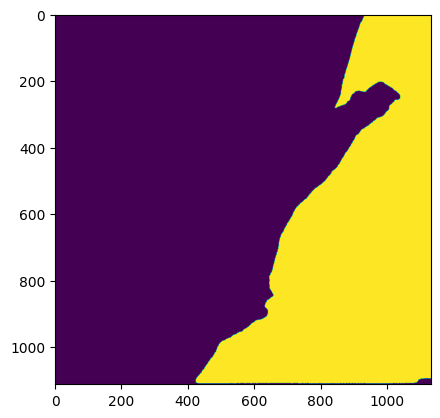

In [18]:
# Let's show the first segmentation mask.
from matplotlib import pyplot
pyplot.imshow(result[0]['segmentation'])

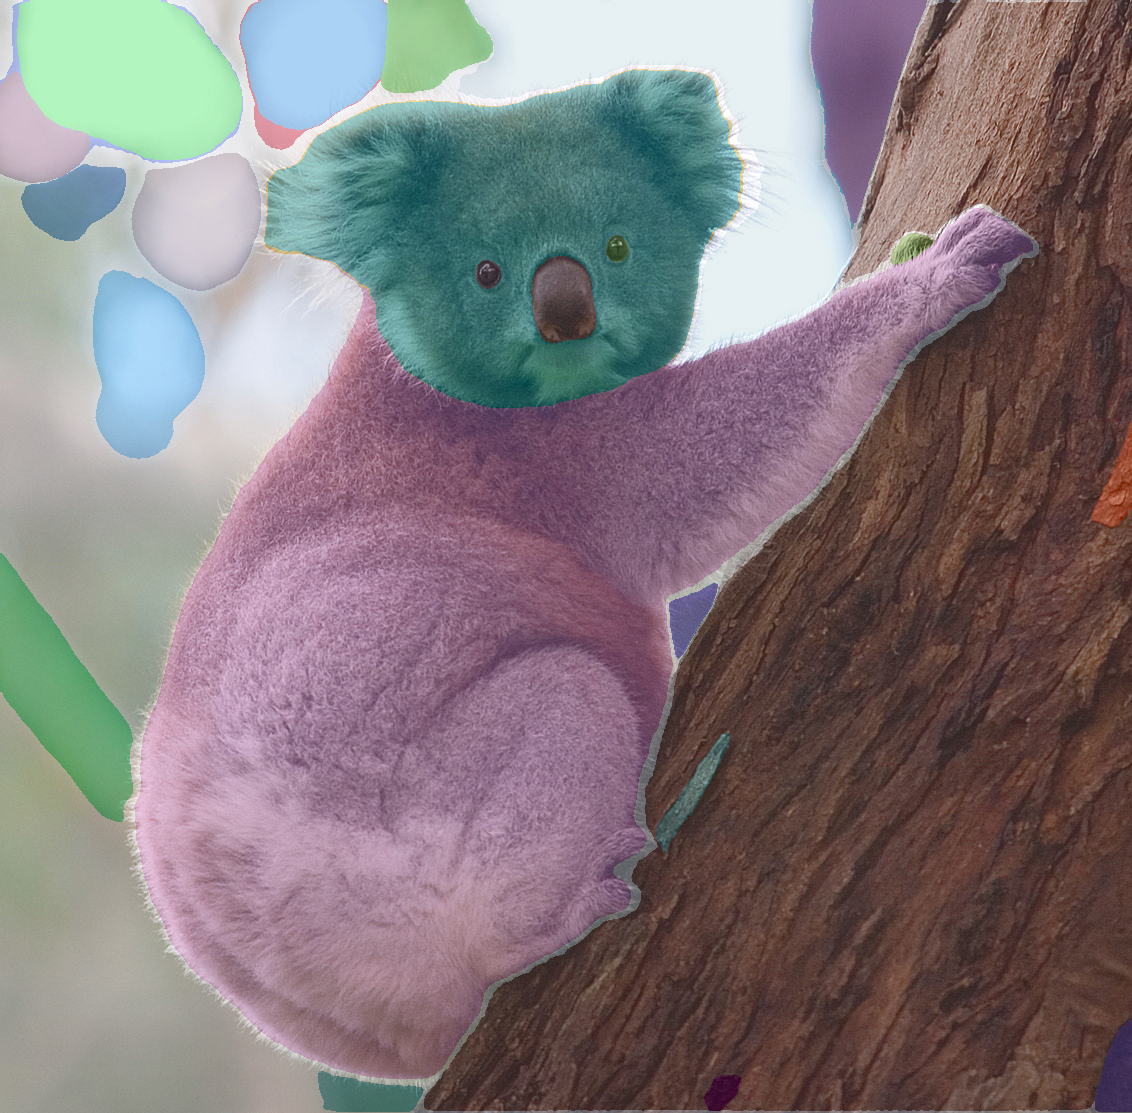

In [19]:
mask = c.generate_mask(
    url="https://upload.wikimedia.org/wikipedia/commons/4/49/Koala_climbing_tree.jpg",
)
from IPython.display import display, Image
display(Image(data=mask, width=400))

In [20]:
# Once we are done, let's shut down the remote service.
!lep deployment remove -n sam

Deployment sam removed.


# Conclusion

This is it! you can find more resources at:
- [the Lepton AI example repo](https://github.com/leptonai/examples)
- [the Lepton AI documentation](https://lepton.ai/docs)

And you are more than welcome to [email us](mailto:info@lepton.ai)